<a href="https://colab.research.google.com/github/SoumyaTeotia/Waiting-Time-Prediction-in-Queueing-Systems/blob/main/bankwait.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib
import os
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.python import keras

In [ ]:
def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i

In [ ]:
arrivalTime = '8:10'
arrivalTime = dt.datetime.strptime(arrivalTime, '%H:%M')
print(arrivalTime)

1900-01-01 08:10:00


In [ ]:
def file_read(path, numberOfRows):
    indexCounter = 0
    with open(path,'r') as file:
        nRows = numberOfRows
        nColumns = 4
        dataset = np.zeros(shape=(nRows, nColumns))
        arrivalTimes = []
        for line in file:
            try:
                dataInstance = line.split(',')
                arrivalTime = dataInstance[1] #splits the line at the comma and takes the first bit
                arrivalTime = dt.datetime.strptime(arrivalTime, '%H:%M')
                arrivalHour = arrivalTime.hour
                arrivalMinute = arrivalTime.minute
                waitingMinutes = dataInstance[2]
                serviceMinutes = dataInstance[3]

                arrivalTimes.append(arrivalTime)
                dataset[indexCounter] = [arrivalHour, arrivalMinute, waitingMinutes, serviceMinutes]
                indexCounter = indexCounter + 1
            except:
                #print('index' + str(indexCounter) + 'error')
                pass
    return dataset, arrivalTimes


In [ ]:
rootFilePath = '/BankDataCsv/'
filename = 'Bank1Week1Day1'
fullPath = rootFilePath + filename + '.csv'
tf, tat = file_read(fullPath, 879)
print(tf)

[[ 8.  0. 11. 28.]
 [ 8.  0. 13. 25.]
 [ 8.  0. 14. 26.]
 ...
 [14. 59. 14. 27.]
 [14. 59. 13. 29.]
 [14. 59. 11. 28.]]


In [ ]:
filenames = []
rootFilePath = '/BankDataCsv/'
fullDataset = pd.DataFrame()
for bankCounter in range(1):
  for weekCounter in range(4):
    for dayCounter in range(5):
      filename = 'Bank' + str(bankCounter + 1) + 'Week' + str(weekCounter + 1) + 'Day' + str(dayCounter + 1)
      fullPath = rootFilePath + filename + '.csv'
      filenames.append(fullPath)

      numberOfRows = file_len(fullPath) - 1
      print ('Reading ' + filename + ' that contains ' + str(numberOfRows) + ' entries')
      tempFeatures, tempArrivalTimes = file_read(rootFilePath + filename + '.csv',numberOfRows)
      #tempFeatures, tempArrivalTimes = file_read(rootFilePath + 'Bank1Week1Day1' + '.csv',numberOfRows)
      dfTempFeatures = pd.DataFrame(np.array(tempFeatures), columns=['hour', 'minutes', 'waitingTime', 'serviceTime'])
      dfTempArrivalTimes = pd.DataFrame(np.array(tempArrivalTimes), columns=['arrivalTime'])
      #print(dfTempFeatures)

      timeLeavingTheQueue = []
      for arrivalTimeCounter in range(numberOfRows):
          timeLeavingTheQueue.append(dfTempArrivalTimes.at[arrivalTimeCounter, 'arrivalTime'] + pd.Timedelta(minutes = dfTempFeatures.at[arrivalTimeCounter, 'waitingTime']))
      dftimeLeavingTheQueue = pd.DataFrame(np.array(timeLeavingTheQueue), columns=['timeLeavingTheQueue'])

      waitingPeople = np.zeros(numberOfRows)
      for i in range(numberOfRows):
        for j in range(i):
          if (dfTempArrivalTimes.at[i, 'arrivalTime'] < dftimeLeavingTheQueue.at[j, 'timeLeavingTheQueue']):
              waitingPeople[i] += 1
      dfWaitingPeople = pd.DataFrame(np.array(waitingPeople), columns=['waitingPeople'])
      dayOfWeek = np.zeros(numberOfRows)
      for i in range(numberOfRows):
          dayOfWeek[i] = dayCounter
      dfDayOfWeek = pd.DataFrame(np.array(dayOfWeek), columns=['dayOfWeek'])
      dfWaitingPeople['waitingPeople'] = dfWaitingPeople['waitingPeople'].astype(int)
      dfTempFeatures['hour'] = dfTempFeatures['hour'].astype(int)
      dfTempFeatures['minutes'] = dfTempFeatures['minutes'].astype(int)
      dfDayOfWeek['dayOfWeek'] = dfDayOfWeek['dayOfWeek'].astype(int)

      tempDataset = pd.concat([dfTempFeatures, dfWaitingPeople, dfDayOfWeek], axis=1)

      fullDataset = pd.concat([fullDataset, tempDataset], axis=0)

fullDataset = fullDataset.reset_index(drop = True)
print(fullDataset.shape[0])

Reading Bank1Week1Day1 that contains 879 entries
Reading Bank1Week1Day2 that contains 719 entries
Reading Bank1Week1Day3 that contains 1019 entries
Reading Bank1Week1Day4 that contains 801 entries
Reading Bank1Week1Day5 that contains 521 entries
Reading Bank1Week2Day1 that contains 988 entries
Reading Bank1Week2Day2 that contains 683 entries
Reading Bank1Week2Day3 that contains 547 entries
Reading Bank1Week2Day4 that contains 1020 entries
Reading Bank1Week2Day5 that contains 788 entries
Reading Bank1Week3Day1 that contains 998 entries
Reading Bank1Week3Day2 that contains 989 entries
Reading Bank1Week3Day3 that contains 1000 entries
Reading Bank1Week3Day4 that contains 1050 entries
Reading Bank1Week3Day5 that contains 981 entries
Reading Bank1Week4Day1 that contains 856 entries
Reading Bank1Week4Day2 that contains 980 entries
Reading Bank1Week4Day3 that contains 1056 entries
Reading Bank1Week4Day4 that contains 898 entries
Reading Bank1Week4Day5 that contains 995 entries
17768


In [ ]:
print(f'The dataset has {fullDataset.shape[0]} rows and {fullDataset.shape[1]} columns.')

The dataset has 17768 rows and 6 columns.


In [ ]:
fullDataset.head()

,hour,minutes,waitingTime,serviceTime,waitingPeople,dayOfWeek
0,8,0,11.0,28.0,0,0
1,8,0,13.0,25.0,1,0
2,8,0,14.0,26.0,2,0
3,8,0,9.0,26.0,3,0
4,8,0,14.0,23.0,4,0


In [ ]:
fullDataset.describe()

,hour,minutes,waitingTime,serviceTime,waitingPeople,dayOfWeek
count,17768.000000,17768.000000,17768.000000,17768.000000,17768.000000,17768.000000
mean,10.584815,28.111099,12.150777,14.695689,27.903534,1.973323
std,2.077604,17.276135,6.433825,5.902357,18.112853,1.406579
min,8.000000,0.000000,3.000000,4.000000,0.000000,0.000000
25%,9.000000,13.000000,8.000000,10.000000,16.000000,1.000000
50%,10.000000,27.000000,10.000000,14.000000,23.000000,2.000000
75%,12.000000,43.000000,15.000000,19.000000,37.000000,3.000000
max,14.000000,59.000000,28.000000,33.000000,163.000000,4.000000


In [ ]:
print(f'There are {fullDataset.isnull().any().sum()} columns in the dataset with missing values.')

There are 0 columns in the dataset with missing values.


In [ ]:
# data to be plotted
mu = fullDataset["waitingPeople"].mean()  # mean of distribution
sigma = fullDataset["waitingPeople"].std()  # standard deviation of distribution
x = fullDataset["waitingPeople"]

num_bins = 100

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=1)

ax.set_xlabel('Number of people waiting when joining the queue')
ax.set_ylabel('Probability density')



NameError: ignored

Text(0, 0.5, 'Probability density')

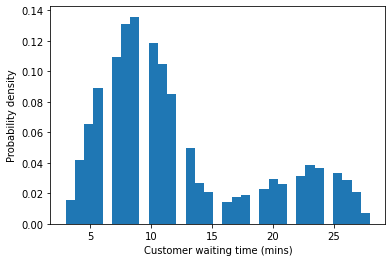

In [ ]:
# data to be plotted
mu = fullDataset["waitingTime"].mean()  # mean of distribution
sigma = fullDataset["waitingTime"].std()  # standard deviation of distribution
x = fullDataset["waitingTime"]

num_bins = 33

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=1)

# add a 'best fit' line
#y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
 #    np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
#ax.plot(bins, y, '--')
ax.set_xlabel('Customer waiting time (mins)')
ax.set_ylabel('Probability density')


In [ ]:
workingCopyDataset = fullDataset
workingCopyDataset.drop(['serviceTime'], axis=1);

In [ ]:
# mean encoding for regression output
def mean_encoder_regression(input_vector, output_vector):
    assert len(input_vector) == len(output_vector)
    numberOfRows = len(input_vector)

    temp = pd.concat([input_vector, output_vector], axis=1)
    # Compute target mean
    averages = temp.groupby(by=input_vector.name)[output_vector.name].agg(["mean", "count"])

    print(averages)
    return_vector = pd.DataFrame(0, index=np.arange(numberOfRows), columns={'feature'})


    for i in range(numberOfRows):
        return_vector.iloc[i] = averages['mean'][input_vector.iloc[i]]

    return return_vector

In [ ]:
encoded_input_vector_hour = mean_encoder_regression(workingCopyDataset['hour'], workingCopyDataset['waitingTime'])
encoded_input_vector_hour.columns = ['hour']
encoded_input_vector_minutes = mean_encoder_regression(workingCopyDataset['minutes'], workingCopyDataset['waitingTime'])
encoded_input_vector_minutes.columns = ['minutes']
encoded_input_vector_dayOfWeek = mean_encoder_regression(workingCopyDataset['dayOfWeek'], workingCopyDataset['waitingTime'])
encoded_input_vector_dayOfWeek.columns = ['dayOfWeek']

           mean  count
hour                  
8     11.823287   3882
9     12.167036   3161
10    11.768293   2214
11    12.412796   2110
12    11.884278   2169
13    11.995631   2060
14    13.261050   2172
              mean  count
minutes                  
0        11.837912    364
1        11.995025    402
2        12.137931    319
3        11.804878    328
4        12.646840    269
5        11.797267    439
6        11.833992    253
7        12.376344    372
8        11.918605    258
9        11.981752    274
10       12.295597    318
11       12.309133    427
12       12.378151    238
13       12.190476    273
14       13.027237    257
15       12.319783    369
16       12.731278    227
17       12.780000    350
18       12.400697    287
19       12.331765    425
20       12.312668    371
21       12.474820    278
22       13.230435    230
23       11.920844    379
24       13.073394    218
25       11.789604    404
26       12.539877    326
27       12.432692    312
28       13.4

In [ ]:
X = pd.concat([encoded_input_vector_hour['hour'], encoded_input_vector_minutes['minutes'], pd.DataFrame(workingCopyDataset['waitingPeople']), encoded_input_vector_dayOfWeek['dayOfWeek']], axis=1)
y = workingCopyDataset['waitingTime']

In [ ]:
X.describe()

,hour,minutes,waitingPeople,dayOfWeek
count,17768.000000,17768.000000,17768.000000,17768.000000
mean,12.150777,12.150777,27.903534,12.150777
std,0.460459,0.470414,18.112853,0.952740
min,11.768293,11.208178,0.000000,11.176146
25%,11.823287,11.837912,16.000000,11.339958
50%,11.995631,12.037037,23.000000,11.927170
75%,12.167036,12.400697,37.000000,12.533033
max,13.261050,13.433962,163.000000,13.872146


In [ ]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.15, random_state=42)
print(trainX.shape, trainy.shape)
print(testX.shape, testy.shape)

(15102, 4) (15102,)
(2666, 4) (2666,)


In [ ]:
def scale_input(X, means, stds):
    return (X - means) / stds

def descale_input(X, means, stds):
    return (X * stds) + means

In [ ]:
meansX = trainX.mean(axis=0)
stdsX = trainX.std(axis=0) + 1e-10

In [ ]:
trainX_scaled = scale_input(trainX, meansX, stdsX)
testX_scaled = scale_input(testX, meansX, stdsX)

In [ ]:
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [ ]:
NN = MLPRegressor(max_iter=500, activation = "relu", hidden_layer_sizes=(100,100))

In [ ]:
NN.fit(trainX,trainy)

NN_pred = NN.predict(testX)

print("MAE    ", mean_absolute_error(testy,NN_pred))


MAE     3.51939840265263


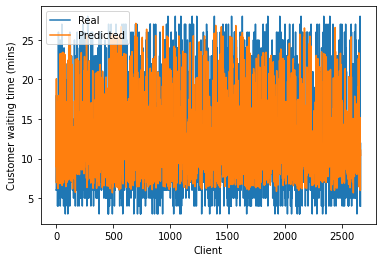

In [ ]:
testy_pred = NN.predict(testX)
myLength = len(testy_pred)
plt.plot(range(myLength), testy)
plt.plot(range(myLength), testy_pred)
plt.ylabel('Customer waiting time (mins)')
plt.xlabel('Client')
plt.legend(['Real', 'Predicted'], loc='upper left')

In [ ]:
myMae = mean_absolute_error(testy, testy_pred)
print(f'The mean absolute error I get with the neural network is {myMae} minutes.')

The mean absolute error I get with the neural network is 3.51939840265263 minutes.
